In [1]:
options(mc.cores = parallel::detectCores())
library(rethinking)
rstan_options(auto_write = TRUE)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


In [2]:
# simulate a pancake and return randomly ordered sides
sim_pancake <- function() {
                                pancake <- sample(1:3,1)
                                sides <- matrix(c(1,1,1,0,0,0),2,3)[,pancake]
                                sample(sides)
                            }
# sim 10,000 pancakes
pancakes <- replicate( 1e4 , sim_pancake() )
up <- pancakes[1,]
down <- pancakes[2,]
# compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 <- sum( up==1 )
num_11 <- sum( up==1 & down==1 )
num_11/num_11_10

[1] 0.6620306

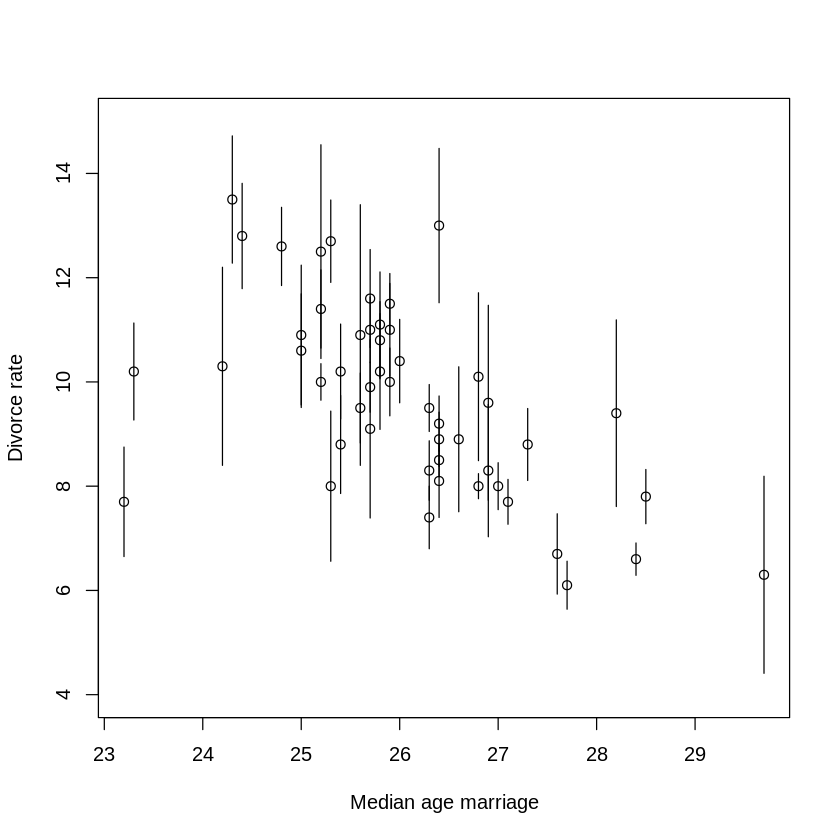

In [3]:
library(rethinking)
data(WaffleDivorce)
d <- WaffleDivorce

# points
plot( d$Divorce ~ d$MedianAgeMarriage , ylim=c(4,15) ,
xlab="Median age marriage" , ylab="Divorce rate" )

# standard errors
for ( i in 1:nrow(d) ) {
                            ci <- d$Divorce[i] + c(-1,1)*d$Divorce.SE[i]
                            x <- d$MedianAgeMarriage[i]
                            lines( c(x,x) , ci )
                        }

In [4]:
dlist <- list(
                D_obs = standardize( d$Divorce ),
                D_sd = d$Divorce.SE / sd( d$Divorce ),
                M = standardize( d$Marriage ),
                A = standardize( d$MedianAgeMarriage ),
                N = nrow(d)
            )

m15.1 <- ulam(
                alist(
                D_obs ~ dnorm( D_true , D_sd ),
                vector[N]:D_true ~ dnorm( mu , sigma ),
                mu <- a + bA*A + bM*M,
                a ~ dnorm(0,0.2),
                bA ~ dnorm(0,0.5),
                bM ~ dnorm(0,0.5),
                sigma ~ dexp(1)
                ) , data=dlist , chains=4 , cores=4 )

In [5]:
precis(m15.1)

50 vector or matrix parameters hidden. Use depth=2 to show them.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.05436326,0.09329586,-0.1998361,0.1033554,1431.1638,1.0012585
bA,-0.61847019,0.15583077,-0.8698199,-0.3753271,932.3796,1.0007646
bM,0.05167089,0.16408933,-0.2098444,0.3060778,820.9518,1.0015735
sigma,0.58103336,0.10651920,0.4187158,0.7626465,689.9418,0.9994353


In [6]:
dlist <- list(
                D_obs = standardize( d$Divorce ),
                D_sd = d$Divorce.SE / sd( d$Divorce ),
                M_obs = standardize( d$Marriage ),
                M_sd = d$Marriage.SE / sd( d$Marriage ),
                A = standardize( d$MedianAgeMarriage ),
                N = nrow(d)
            )

m15.2 <- ulam(
                alist(
                    D_obs ~ dnorm( D_est , D_sd ),
                    vector[N]:D_est ~ dnorm( mu , sigma ),
                    mu <- a + bA*A + bM*M_est[i],
                    M_obs ~ dnorm( M_est , M_sd ),
                    vector[N]:M_est ~ dnorm( 0 , 1 ),
                    a ~ dnorm(0,0.2),
                    bA ~ dnorm(0,0.5),
                    bM ~ dnorm(0,0.5),
                    sigma ~ dexp( 1 )
                ) , data=dlist , chains=4 , cores=4 )

In [7]:
precis(m15.2)

100 vector or matrix parameters hidden. Use depth=2 to show them.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.0387963,0.09736882,-0.1952863,0.1177888,1933.9642,1.0008433
bA,-0.5394638,0.16317094,-0.7973423,-0.2846536,1073.2569,0.9997915
bM,0.1992213,0.21243779,-0.1436250,0.5269931,919.0552,0.9989326
sigma,0.5624056,0.11367643,0.3973727,0.7526617,573.6686,1.0047799


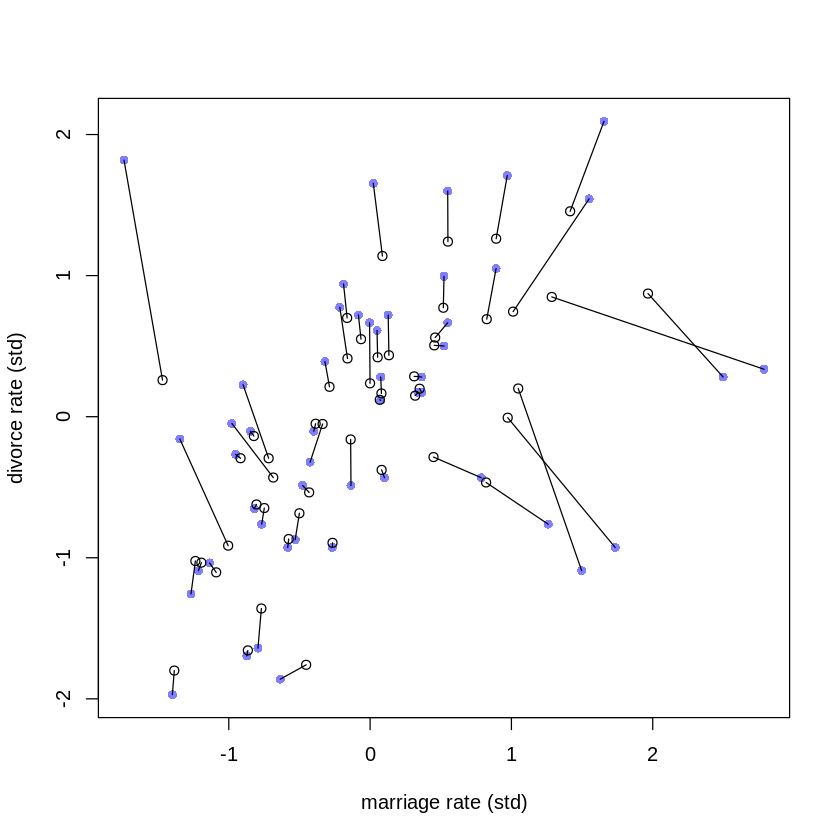

In [8]:
post <- extract.samples( m15.2 )

D_est <- apply( post$D_est , 2 , mean )
M_est <- apply( post$M_est , 2 , mean )

plot( dlist$M_obs , dlist$D_obs , pch=16 , col=rangi2, 
                 xlab="marriage rate (std)" , ylab="divorce rate (std)" )
points( M_est , D_est )
for ( i in 1:nrow(d) ) lines( c( dlist$M_obs[i] , M_est[i] ) , c( dlist$D_obs[i] , D_est[i] ) )

(Page 498) "Another pattern of measurement error to worry about is when a causal variable is mea-
sured less precisely than a non-causal variable. Suppose for example that we know D and M
very precisely but that now A is measured with error. Also assume that M has zero causal
effect on D...  In this circumstance, it can happen that a naive regression of D on A obs and M will strongly suggest that M is associated with D. The reason is that M contains information about the true A. And M is measured more precisely than A is. It’s like a proxy A. Here’s a small simulation
you can toy with that will produce such a frustration:" 

In [9]:
N <- 500L
A <- rnorm(N)
M <- rnorm(N,-A)
D <- rnorm(N,A)
A_obs <- rnorm(N,A)

In [10]:
dat <- list(N=N, A_obs=A_obs, M=M, D=D)

m15terror <- ulam(
                alist(
                    D ~ dnorm( mu , sigma ),
#                     vector[N]:D_est ~ dnorm( mu , sigma ),
                    mu <- a + bA*A_obs + bM*M,
#                     A_obs ~ dnorm( A_est , A_sd ),
#                     vector[N]:A_est ~ dnorm( 0 , 1 ),
                    a ~ dnorm(0,0.2),
                    bA ~ dnorm(0,0.5),
                    bM ~ dnorm(0,0.5),
                    sigma ~ dexp( 1 )
                ) , data=dat , chains=4 , cores=4 )

In [11]:
precis(m15terror)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.0245218,0.04720830,-0.05033587,0.1008560,2113.237,0.9987954
bA,0.3854386,0.04127854,0.32061019,0.4514843,1863.501,0.9993241
bM,-0.3340980,0.04087026,-0.40079606,-0.2704941,2133.146,0.9994841
sigma,1.1145636,0.03497975,1.06177304,1.1717998,2233.432,0.9996247


In [12]:
dat2 <- list(N=N, A=A, M=M, D=D)

m15terror2 <- ulam(
                alist(
                    D ~ dnorm( mu , sigma ),
#                     vector[N]:D_est ~ dnorm( mu , sigma ),
                    mu <- a + bA*A + bM*M,
#                     A_obs ~ dnorm( A_est , A_sd ),
#                     vector[N]:A_est ~ dnorm( 0 , 1 ),
                    a ~ dnorm(0,0.2),
                    bA ~ dnorm(0,0.5),
                    bM ~ dnorm(0,0.5),
                    sigma ~ dexp( 1 )
                ) , data=dat2 , chains=4 , cores=4 )

Using the noisy A_obs, bM has a larger magnitude than bA, despite D being caused only by A.

Below, we swap A_obs for the real A to see the effect:

In [13]:
precis(m15terror2)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.02261662,0.04216889,-0.04464741,0.09160118,1639.868,1.000452
bA,0.98073542,0.06081515,0.88308281,1.07859602,1088.350,1.000068
bM,-0.02872516,0.04372350,-0.09735026,0.04259677,1121.727,1.001241
sigma,0.98661094,0.03188413,0.93628432,1.03733256,1841.687,1.001534


In this case, the coefficient bA has a value much more true to the real value of 1, and bM much close to the real value of 0.

(Page 499): "When you have your own data and your own particular measurement concerns, all of
this can be overwhelming. But the way to proceed is same as always: Use your background
knowledge to write down a generative model or models, simulate data from these models in
order to understand the inferential risks, and design a statistical approach that can work at
least in theory."

In [14]:
N <- 100
S <- rnorm( N )
H <- rbinom( N , size=10 , inv_logit(S) )
H

[1]  8  3  5  3  5  6  6  5  5  4  7  5  2  3  3  4  4  5  1  6  9  3  3  5  7
 [26]  4  6  2  6  3  4  5  3  0  6  3  6  6  9  4  5  2  6  7  4  8  3  9  3  1
 [51]  7  3  9  4  2  8  1  6  3  7  8  5  9  3  5  6  6  9 10  7  4  5  7  7  5
 [76]  8  3  3  3  4  6 10  6  3  5  6  6  5  2  8  4  7  3  5  4  2  6  4  4  3

In [15]:
D <- rbern( N ) # dogs completely random
Hm <- H
Hm[D==1] <- NA
Hm

[1]  8 NA  5 NA NA NA NA  5 NA NA NA  5  2  3  3 NA  4  5 NA  6  9  3 NA NA NA
 [26] NA  6 NA  6  3  4 NA NA  0  6  3 NA  6  9  4  5 NA  6 NA NA NA  3  9  3 NA
 [51] NA  3 NA  4 NA  8 NA NA NA  7 NA NA  9  3 NA  6 NA NA NA  7 NA NA NA  7 NA
 [76]  8  3  3 NA  4  6 NA NA NA NA  6  6  5  2 NA NA NA  3  5 NA  2 NA NA NA NA

In [16]:
D <- ifelse( S > 0 , 1 , 0 )
Hm <- H
Hm[D==1] <- NA
Hm

[1] NA  3 NA  3  5 NA  6  5  5  4 NA  5  2  3  3 NA NA  5  1  6 NA  3  3  5 NA
 [26] NA NA  2 NA  3  4 NA NA  0 NA  3 NA NA NA NA NA  2  6 NA  4 NA  3 NA NA  1
 [51]  7 NA NA  4  2 NA  1  6  3 NA NA  5 NA  3  5  6  6 NA NA NA  4  5 NA NA  5
 [76] NA  3  3  3  4  6 NA  6  3  5 NA NA NA  2 NA NA  7  3 NA  4  2 NA  4  4  3

In [17]:
set.seed(501)
N <- 1000
X <- rnorm(N)
S <- rnorm(N)
H <- rbinom( N , size=10 , inv_logit( 2 + S - 2*X ) )
D <- ifelse( X > 1 , 1 , 0 )
Hm <- H
Hm[D==1] <- NA
Hm

[1] 10  7  9  8 10 10 10  8  7 NA  7  5  9  5  8  8  9 NA 10  5 NA 10  8  4
  [25] 10  9 NA  9 10  6  9  9  2  7 NA  9  7  6  9  8 10  8 NA  7  8 NA NA  8
  [49] 10 NA NA 10 10 NA 10 10  5 10 NA 10 10 NA  5  6 NA 10  5  5 NA NA  7  8
  [73] 10 10  7 NA 10 10 10  8  9  5  7  6  9 NA  8 NA  7  7  7  8  5 10 10  9
  [97]  5 10  9  7 10  9  8  7 10 NA 10  1 10  8 10 10 10  8 NA NA  9  8 10  8
 [121]  7 10 10 NA NA 10  7  9 10  9  9  5 NA 10  6  8  9 10  9  7  9  4  9 10
 [145]  5 NA 10 10  5 10 10  5 NA NA 10  4  3  7  3  4  2 NA NA 10 10  6 NA  7
 [169]  5 10  9 10 10 NA NA NA 10 10 NA  5 10  9  8  9 NA NA  9  9 10  9  9 10
 [193]  9 10  9 NA 10  9  8  3 10 10  7 10  6 NA 10  8  8 10 NA NA NA  8 NA  9
 [217] 10  8  5  6 10 NA NA  7  2 10 10 10 10  4 10  4 10  8  5 10 10  9  8  8
 [241]  9  9  9 10  6 NA  9 10  9 10 10  9  9  9 10  9  8  5  7 NA  6  8  8  9
 [265]  9 10  9 10  7  7  8  6  4 NA 10 10 NA NA  9 10 NA  7 10 NA 10 NA  8  9
 [289] 10  9 NA  4 10  4  9  7  6  5 10  5  7 NA  5 10  9  9 NA 10 10  4  9 10
 [313] 10 10 10 10 NA  6 NA  4 10 10  7  5 NA 10 10  9 NA 10  8 10  5 10 10 10
 [337] 10 NA  6 10 NA 10 10  8  0 10 10  9  9  6  8 10 10  9 NA  8 10  7 10  7
 [361] 10 NA 10  7 10 NA  7 10 NA  9  7 NA 10  4  6  8 10 NA 10  3  9 10  9 10
 [385] 10  8 10  9  8 10 10 NA 10 10  9  9 10 10  8 NA 10  9 NA  7  7 NA NA  3
 [409] 10 10  7 10  5 NA  5 NA NA NA 10 10 10  9  4 NA 10 10 10 NA  9  9 10 NA
 [433] NA NA  9 10  9  6  7  9  2  8 10  7 NA 10 10 10  9 NA NA 10 10  8 10  8
 [457] 10  6  8  8  2  9  6 10 10 10 10  8 10 10 NA NA NA  8  8 NA  4  8 NA  8
 [481]  9 NA NA  6  9  8  9  9  7 NA NA 10  7  4  7 10  3  4  9 10 NA 10  9  9
 [505] 10 10 10 NA  9  7  9  8 NA  8 10 10  9 NA 10  9 NA  7  9  9 NA  9  9  9
 [529] 10 10 NA  6  8  4  8 NA  9 10 10  5 10 NA 10  9  7  6  4 10 10  9  6  9
 [553] NA  5 10  7  7  9 10 NA  9  8 NA 10  9 10  9  8 NA  5  8  9  9 10 10 10
 [577]  9 10 10  7 NA 10  8 10  6  9 NA 10 NA  9 10 10 NA  9  2 10 NA NA 10  7
 [601]  6  5  4 NA  7  8 10  0  9 NA  4  7  9  9  4 10 10 10 10  9 NA 10 10 NA
 [625] NA 10  8 10  6 10  6 NA  9  8  9  8 NA  8  3 10 10  8 NA 10 10  9 10 NA
 [649]  8 10  9  9 10  4 10  8  9 NA  8  8 10  5  9  9  8  9 10 10  8  5 10 NA
 [673] 10  6  9 10 10 NA NA 10  7 NA 10  9 10 10 NA  9 10 NA NA 10  7 10  8  8
 [697] 10  1  9  9 NA 10 10  9  8  8  7 10 10  5 10  7  8 NA 10 NA 10  4  9 NA
 [721] NA  8 10  7  9  9 10  7  7 NA  9  9  9  9 10  8  5 10 NA  8 10 10 NA 10
 [745] NA NA 10 NA 10 10 10 NA  9 10  9  9 10  8  3  9 NA 10  6 10 10  9  7  7
 [769] 10 10  6  7 10  8  9 10 10 NA NA 10 NA NA  9  9  5  9 10 NA 10  9 10  9
 [793]  9 10 10 10  9 NA  7 10  4 NA 10 NA  2  5 10 10  6 10  9 10 10 10 10  8
 [817]  9  9 10 NA 10  9  9  6  9 10 10  9  7  3 NA NA  9  8  9 10 NA 10  9  8
 [841] 10  9 NA NA 10 10 10  9 10 10 NA  7  9 10  9  8  9  6 10  8  4  9  7  9
 [865] NA NA  9 10 10  6  9 10 NA  8 10  8  9  8 10  5 10 10  9  9  6  6  0  9
 [889] 10  2  4 10  8  5 10  5 NA 10 NA  9  9 10 NA 10 10  9 10 NA  8  4 10 NA
 [913]  5 10 10  9  7  9  9 10 10 10 10 10  8 NA  9  2 NA  8 10  8 10  9  7 10
 [937]  9  9 10  8  3 NA  8 10  9 10 NA NA  6  8 NA 10  4  8 NA  6 10 10 10 NA
 [961]  9 10  3 10 10  8  7 10 10  9 10  0  9 10 NA  8  9  7 NA  9 10 10 10  7
 [985] 10 10  8 NA NA  9  6  0  7  8 NA  1  7  6  8 NA

In [18]:
dat_list <- list(
                H = H,
                S = S )

m15.3 <- ulam(
            alist(
            H ~ binomial( 10 , p ),
            logit(p) <- a + bS*S,
            a ~ normal( 0 , 1 ),
            bS ~ normal( 0 , 0.5 )
            ), data=dat_list , chains=4, cores=4 )

precis( m15.3 )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,1.1132392,0.02437284,1.0742736,1.1522656,1271.851,0.9988954
bS,0.6894842,0.02622617,0.6477503,0.7312538,1000.906,0.9997910


In [19]:
dat_listD <- list(
                H = H,
                S = S,
                D = D)

m15.3.D <- ulam(
            alist(
            H ~ binomial( 10 , p ),
            logit(p) <- a + bS*S + bD*D,
            a ~ normal( 0 , 1 ),
            c(bS, bD) ~ normal( 0 , 0.5 )
            ), data=dat_listD , chains=4, cores=4 )

precis( m15.3.D )

Cautionary note:
Variable D contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,1.7907609,0.03362263,1.7390616,1.8458455,915.7619,1.006291
bD,-2.7213566,0.06505645,-2.8291727,-2.6184324,999.7674,1.000946
bS,0.8406886,0.03080758,0.7922669,0.8907095,1149.4056,1.000870


In [20]:
dat_listX <- list(
                H = H,
                S = S,
                X = X)

m15.3.X <- ulam(
            alist(
            H ~ binomial( 10 , p ),
            logit(p) <- a + bS*S + bX*X,
            a ~ normal( 0 , 1 ),
            c(bS, bX) ~ normal( 0 , 0.5 )
            ), data=dat_listX , chains=4, cores=4 )

precis( m15.3.X )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,1.928300,0.03951772,1.8647266,1.992924,1041.075,1.003834
bX,-1.927370,0.04312106,-1.9985837,-1.860865,1012.587,1.004399
bS,1.003477,0.03320798,0.9486627,1.056275,1275.153,1.003649


In [21]:
dat_listXD <- list(
                H = H,
                S = S,
                X = X,
                D = D)

m15.3.XD <- ulam(
            alist(
            H ~ binomial( 10 , p ),
            logit(p) <- a + bS*S + bX*X + bD*D,
            a ~ normal( 0 , 1 ),
            c(bS, bX, bD) ~ normal( 0 , 0.5 )
            ), data=dat_listXD , chains=4, cores=4 )

precis( m15.3.XD )

Cautionary note:
Variable D contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,1.9320519,0.04072932,1.8681425,1.9996738,944.9902,1.005702
bD,-0.1388257,0.09526763,-0.2887371,0.0194945,1071.2493,1.003430
bX,-1.8672374,0.06221448,-1.9678737,-1.7670860,979.2786,1.001378
bS,1.0038339,0.03389381,0.9510981,1.0577222,1153.5328,1.002938


In [22]:
dat_list0 <- list(
                H = H[D==0],
                S = S[D==0] )

m15.4 <- ulam(
                alist(
                H ~ binomial( 10 , p ),
                logit(p) <- a + bS*S,
                a ~ normal( 0 , 1 ),
                bS ~ normal( 0 , 0.5 )
                ), data=dat_list0 , chains=4, cores=4 )

precis( m15.4 )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,1.7978523,0.03408515,1.7435561,1.8515247,951.1366,1.001015
bS,0.8282779,0.03280287,0.7759204,0.8797448,979.2805,1.003745


In [23]:
N <- 100
S <- rnorm(N)
H <- rbinom( N , size=10 , inv_logit(S) )
D <- ifelse( H < 5 , 1 , 0 )
Hm <- H
Hm[D==1] <- NA

In [24]:
dat <- list(
                H = H[D==0],
                S = S[D==0] )

m15.4.2 <- ulam(
                alist(
                H ~ binomial( 10 , p ),
                logit(p) <- a + bS*S,
                a ~ normal( 0 , 1 ),
                bS ~ normal( 0 , 0.5 )
                ), data=dat , chains=4, cores=4 )

precis( m15.4.2 )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.5019711,0.1144139,0.3146823,0.6850267,689.3442,1.002223
bS,0.6146122,0.1196263,0.4285547,0.8053939,721.5866,1.001049


In [89]:
library(rethinking)
data(milk)
d <- milk
head(d)
d$neocortex.prop <- d$neocortex.perc / 100
d$logmass <- log(d$mass)

clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NA
Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NA
Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NA
Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NA
New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54


In [90]:
dat_list <- list(
                    K = standardize( d$kcal.per.g ),
                    B = standardize( d$neocortex.prop ),
                    M = standardize( d$logmass )
                )

m15.3 <- ulam(
            alist(
                K ~ dnorm( mu , sigma ),
                mu <- a + bB*B + bM*M,
                B ~ dnorm( nu , sigma_B ),
                c(a,nu) ~ dnorm( 0 , 0.5 ),
                c(bB,bM) ~ dnorm( 0, 0.5 ),
                sigma_B ~ dexp( 1 ),
                sigma ~ dexp( 1 )
            ) , data=dat_list , chains=4 , cores=4, log_lik=TRUE )

Found 12 NA values in B and attempting imputation.
recompiling to avoid crashing R session


In [27]:
precis(m15.3, depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
nu,-0.04776883,0.2167871,-0.38904797,0.3047852,1814.1533,1.0021029
a,0.03089314,0.1736653,-0.24847464,0.3092366,2350.0772,0.9999086
bM,-0.53826413,0.2020388,-0.85564199,-0.2188622,1017.6232,0.9991314
bB,0.48385869,0.2364452,0.09037191,0.8564518,745.5231,0.9993933
sigma_B,1.01382710,0.1733189,0.76960816,1.3065915,1656.3737,0.9989164
sigma,0.84714833,0.1434881,0.64176585,1.0987947,898.2756,1.0012669
B_impute[1],-0.58950275,0.9438343,-2.04273248,0.8967165,1671.9867,1.0020250
B_impute[2],-0.65721986,0.9660706,-2.14851591,0.9241868,1558.2593,0.9997475
B_impute[3],-0.71098972,0.9717550,-2.20704412,0.8651498,1831.3957,1.0009000


In [91]:
obs_idx <- which( !is.na(d$neocortex.prop) )
dat_list_obs <- list(
                        K = dat_list$K[obs_idx],
                        B = dat_list$B[obs_idx],
                        M = dat_list$M[obs_idx]
                    )

m15.4 <- ulam(
            alist(
                K ~ dnorm( mu , sigma ),
                mu <- a + bB*B + bM*M,
                B ~ dnorm( nu , sigma_B ),
                c(a,nu) ~ dnorm( 0 , 0.5 ),
                c(bB,bM) ~ dnorm( 0, 0.5 ),
                sigma_B ~ dexp( 1 ),
                sigma ~ dexp( 1 )
            ) , data=dat_list_obs , chains=4 , cores=4, log_lik=TRUE )

precis( m15.4 )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
nu,-0.01026855,0.2267144,-0.3846292,0.3534292,1359.879,0.9994136
a,0.10002443,0.1999283,-0.2190114,0.4099493,1859.587,0.9993047
bM,-0.64268514,0.2585331,-1.0250808,-0.2118717,1033.430,1.0038065
bB,0.60729312,0.2812390,0.1517162,1.0355553,989.569,1.0019915
sigma_B,1.04335507,0.1854795,0.7873822,1.3711061,1723.730,0.9992017
sigma,0.87953272,0.1934435,0.6231979,1.2239177,1171.760,1.0000443


In [29]:
coeftab(m15.3, m15.4)

             m15.3   m15.4  
nu             -0.05    0.00
a               0.03    0.10
bM             -0.54   -0.63
bB              0.48    0.59
sigma_B         1.01    1.04
sigma           0.85    0.88
B_impute[1]    -0.59      NA
B_impute[2]    -0.66      NA
B_impute[3]    -0.71      NA
B_impute[4]    -0.29      NA
B_impute[5]     0.44      NA
B_impute[6]    -0.18      NA
B_impute[7]     0.17      NA
B_impute[8]     0.28      NA
B_impute[9]     0.51      NA
B_impute[10]   -0.44      NA
B_impute[11]   -0.29      NA
B_impute[12]    0.14      NA
nobs              29      17

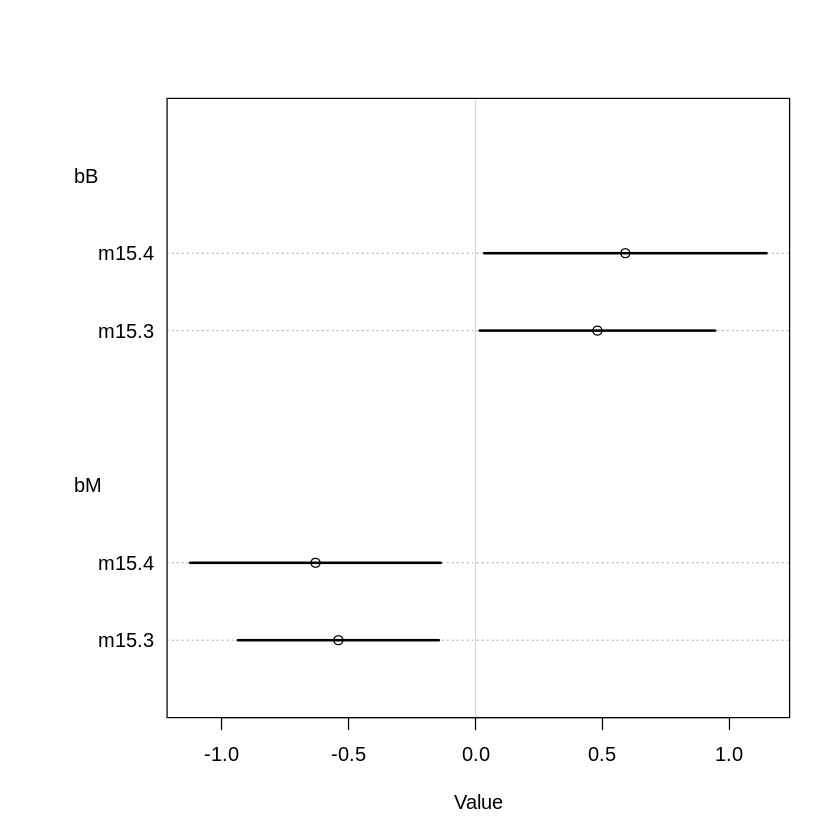

In [30]:
plot(coeftab(m15.3, m15.4), pars=c("bB","bM"))

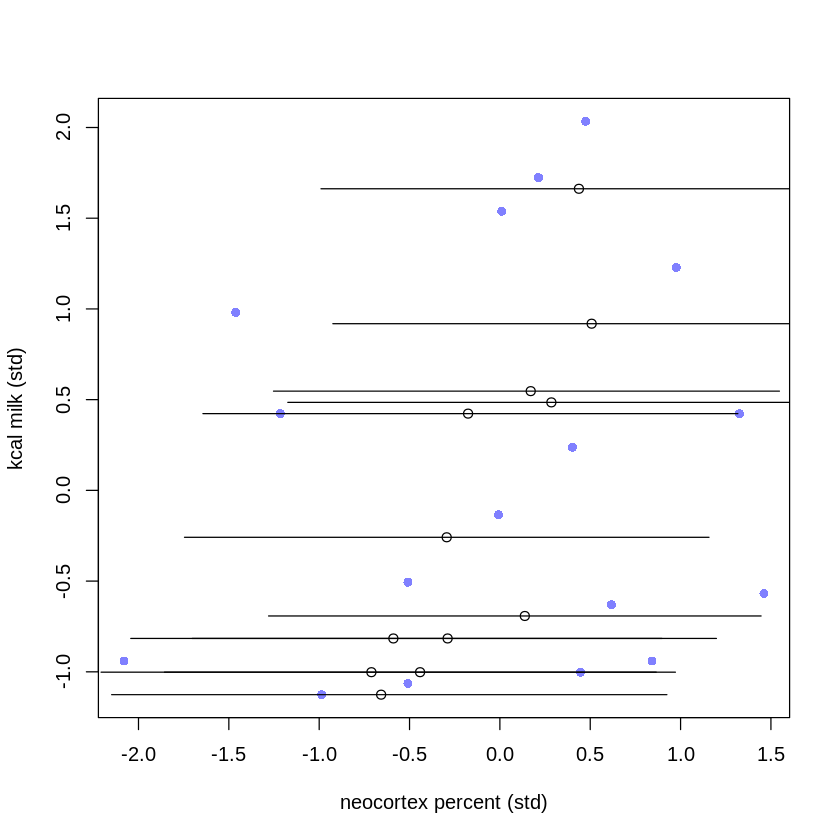

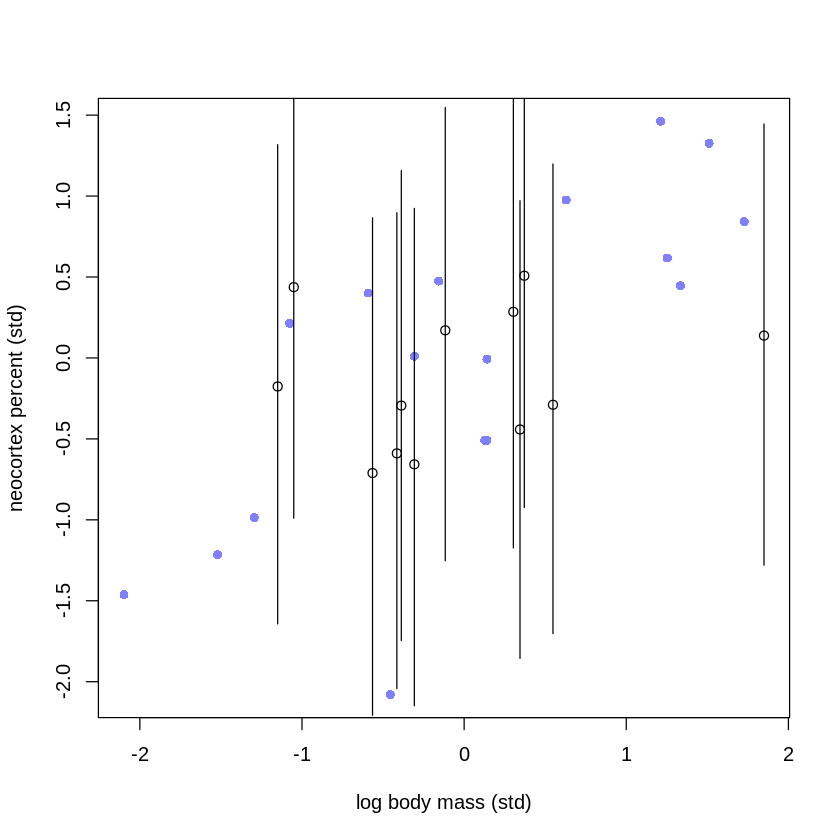

In [31]:
post <- extract.samples( m15.3 )
B_impute_mu <- apply( post$B_impute , 2 , mean )
B_impute_ci <- apply( post$B_impute , 2 , PI )

# B vs K
plot( dat_list$B , dat_list$K , pch=16 , col=rangi2 ,
xlab="neocortex percent (std)" , ylab="kcal milk (std)" )
miss_idx <- which( is.na(dat_list$B) )
Ki <- dat_list$K[miss_idx]
points( B_impute_mu , Ki )
for ( i in 1:12 ) lines( B_impute_ci[,i] , rep(Ki[i],2) )

# M vs B
plot( dat_list$M , dat_list$B , pch=16 , col=rangi2 ,
ylab="neocortex percent (std)" , xlab="log body mass (std)" )
Mi <- dat_list$M[miss_idx]
points( Mi , B_impute_mu )
for ( i in 1:12 ) lines( rep(Mi[i],2) , B_impute_ci[,i] )

In [32]:
m15.5 <- ulam(
            alist(
                # K as function of B and M
                K ~ dnorm( mu , sigma ),
                mu <- a + bB*B_merge + bM*M,
                # M and B correlation
                MB ~ multi_normal( c(muM,muB) , Rho_BM , Sigma_BM ),
                matrix[29,2]:MB <<- append_col( M , B_merge ),
                # define B_merge as mix of observed and imputed values
                vector[29]:B_merge <- merge_missing( B , B_impute ),
                # priors
                c(a,muB,muM) ~ dnorm( 0 , 0.5 ),
                c(bB,bM) ~ dnorm( 0, 0.5 ),
                sigma ~ dexp( 1 ),
                Rho_BM ~ lkj_corr(2),
                Sigma_BM ~ exponential(1)
            ) , data=dat_list , chains=4 , cores=4, log_lik=TRUE )

precis( m15.5 , depth=3 , pars=c("bM","bB","Rho_BM" ) )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bM,-0.6409411,2.174878e-01,-0.9864655,-0.2713627,1527.5114,1.0010459
bB,0.5774189,2.537118e-01,0.1480457,0.9837012,1234.0147,1.0004395
"Rho_BM[1,1]",1.0000000,0.000000e+00,1.0000000,1.0000000,NaN,NaN
"Rho_BM[1,2]",0.6050333,1.354847e-01,0.3631963,0.7937963,1920.6164,0.9991144
"Rho_BM[2,1]",0.6050333,1.354847e-01,0.3631963,0.7937963,1920.6164,0.9991144
"Rho_BM[2,2]",1.0000000,6.859084e-17,1.0000000,1.0000000,922.6416,0.9979980


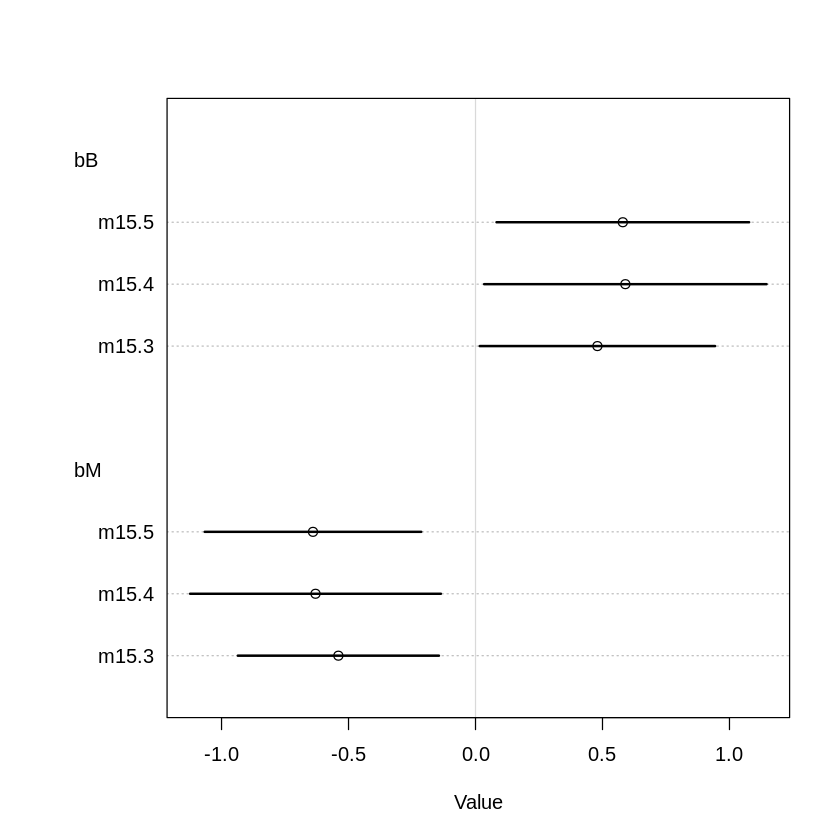

In [33]:
plot(coeftab(m15.3, m15.4, m15.5), pars=c("bB","bM"))

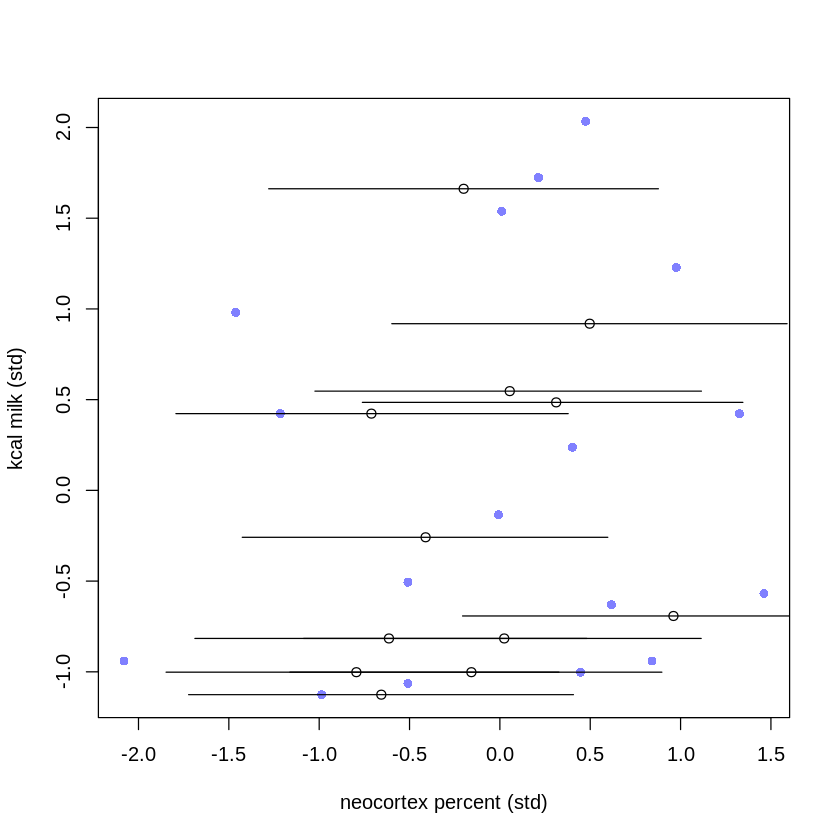

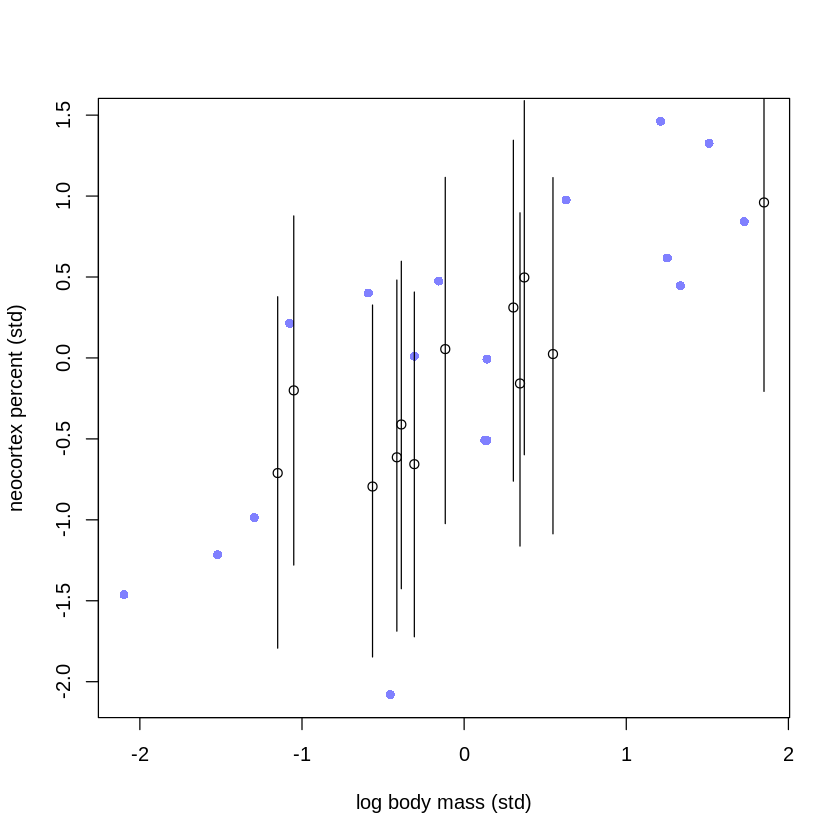

In [34]:
post <- extract.samples( m15.5 )
B_impute_mu <- apply( post$B_impute , 2 , mean )
B_impute_ci <- apply( post$B_impute , 2 , PI )

# B vs K
plot( dat_list$B , dat_list$K , pch=16 , col=rangi2 ,
xlab="neocortex percent (std)" , ylab="kcal milk (std)" )
miss_idx <- which( is.na(dat_list$B) )
Ki <- dat_list$K[miss_idx]
points( B_impute_mu , Ki )
for ( i in 1:12 ) lines( B_impute_ci[,i] , rep(Ki[i],2) )

# M vs B
plot( dat_list$M , dat_list$B , pch=16 , col=rangi2 ,
ylab="neocortex percent (std)" , xlab="log body mass (std)" )
Mi <- dat_list$M[miss_idx]
points( Mi , B_impute_mu )
for ( i in 1:12 ) lines( rep(Mi[i],2) , B_impute_ci[,i] )

In [35]:
compare(m15.3, m15.5)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m15.5,75.71978,4.604177,0.000000,0.7214093,5.826069,NA
m15.3,77.62271,4.986581,1.902926,0.2785907,5.762006,0.9489288


In [36]:
stancode(m15.3)

functions{


    vector merge_missing( int[] miss_indexes , vector x_obs , vector x_miss ) {
        int N = dims(x_obs)[1];
        int N_miss = dims(x_miss)[1];
        vector[N] merged;
        merged = x_obs;
        for ( i in 1:N_miss )
            merged[ miss_indexes[i] ] = x_miss[i];
        return merged;
    }
}
data{
    vector[29] K;
    vector[29] M;
    vector[29] B;
    int B_missidx[12];
}
parameters{
    real nu;
    real a;
    real bM;
    real bB;
    real<lower=0> sigma_B;
    real<lower=0> sigma;
    vector[12] B_impute;
}
model{
    vector[29] mu;
    vector[29] B_merge;
    sigma ~ exponential( 1 );
    sigma_B ~ exponential( 1 );
    bB ~ normal( 0 , 0.5 );
    bM ~ normal( 0 , 0.5 );
    a ~ normal( 0 , 0.5 );
    nu ~ normal( 0 , 0.5 );
    B_merge = merge_missing(B_missidx, to_vector(B), B_impute);
    B_merge ~ normal( nu , sigma_B );
    for ( i in 1:29 ) {
        mu[i] = a + bB * B_merge[i] + bM * M[i];
    }
    K ~ normal( mu , sigma );
}
generated qu

In [37]:
data(Moralizing_gods)
str(Moralizing_gods)

'data.frame':	864 obs. of  5 variables:
 $ polity         : Factor w/ 30 levels "Big Island Hawaii",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ year           : int  1000 1100 1200 1300 1400 1500 1600 1700 1800 -600 ...
 $ population     : num  3.73 3.73 3.6 4.03 4.31 ...
 $ moralizing_gods: int  NA NA NA NA NA NA NA NA 1 NA ...
 $ writing        : int  0 0 0 0 0 0 0 0 0 0 ...


In [38]:
d <- Moralizing_gods
head(d)

polity,year,population,moralizing_gods,writing
<fct>,<int>,<dbl>,<int>,<int>
Big Island Hawaii,1000,3.729643,NA,0
Big Island Hawaii,1100,3.729643,NA,0
Big Island Hawaii,1200,3.598340,NA,0
Big Island Hawaii,1300,4.026240,NA,0
Big Island Hawaii,1400,4.311767,NA,0
Big Island Hawaii,1500,4.205113,NA,0


In [39]:
table( Moralizing_gods$moralizing_gods , useNA="always" )


   0    1 <NA> 
  17  319  528 

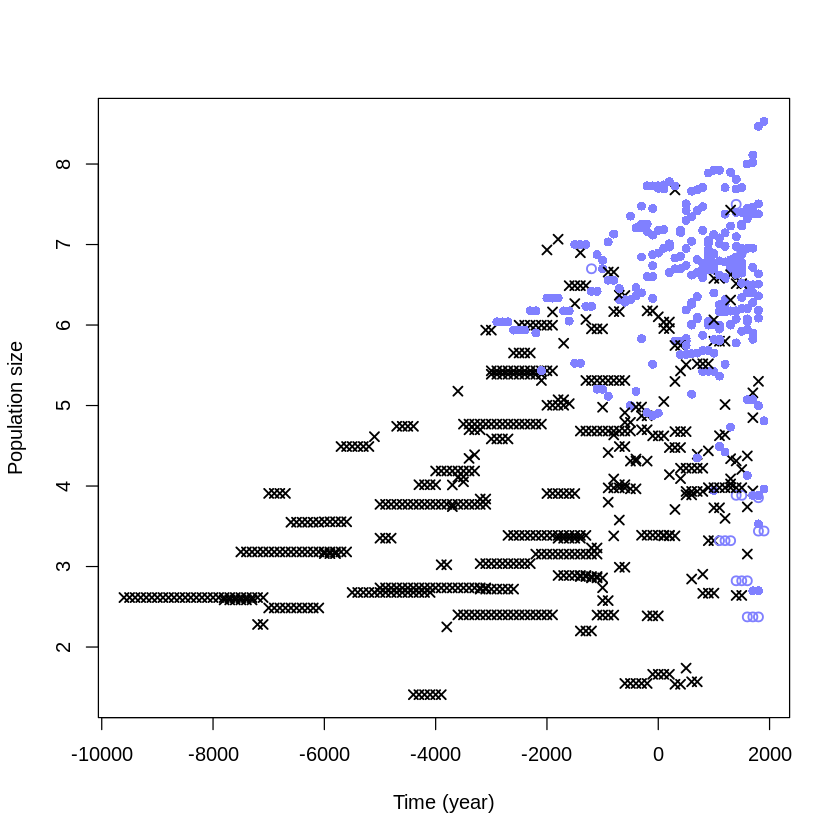

In [40]:
symbol <- ifelse( Moralizing_gods$moralizing_gods==1 , 16 , 1 )
symbol <- ifelse( is.na(Moralizing_gods$moralizing_gods) , 4 , symbol )
color <- ifelse( is.na(Moralizing_gods$moralizing_gods) , "black" , rangi2 )
plot( Moralizing_gods$year , Moralizing_gods$population , pch=symbol ,
col=color , xlab="Time (year)" , ylab="Population size" , lwd=1.5 )

In [41]:
dmg <- Moralizing_gods
table( gods=dmg$moralizing_gods , literacy=dmg$writing , useNA="always" )

      literacy
gods     0   1 <NA>
  0     16   1    0
  1      9 310    0
  <NA> 442  86    0

In [42]:
dmg <- Moralizing_gods
haw <- which( dmg$polity=="Big Island Hawaii" )
t( dmg[ haw , c("year","population","writing","moralizing_gods") ] )

,1,2,3,4,5,6,7,8,9
year,1000.000000,1100.000000,1200.00000,1300.00000,1400.000000,1500.000000,1600.00000,1700.000000,1800.000000
population,3.729643,3.729643,3.59834,4.02624,4.311767,4.205113,4.37396,5.157593,4.997439
writing,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
moralizing_gods,NA,NA,NA,NA,NA,NA,NA,NA,1.000000


In [43]:
set.seed(9)
N_houses <- 100L
alpha <- 5
beta <- (-3)
k <- 0.5
r <- 0.2
cat <- rbern( N_houses , k )
notes <- rpois( N_houses , alpha + beta*cat )
R_C <- rbern( N_houses , r )
cat_obs <- cat
cat_obs[R_C==1] <- (-9L)

In [52]:
dat <- list(
            notes = notes,
            cat = cat_obs,
            RC = R_C,
            N = as.integer(N_houses) )

m15.6 <- ulam(
            alist(
                # singing bird model
                
                ## cat known present/absent:
                notes|RC==0 ~ poisson( lambda ),
                log(lambda) <- a + b*cat,
                
                ## cat NA:
                notes|RC==1 ~ custom( log_sum_exp(
                                        log(k) + poisson_lpmf( notes | exp(a + b) ),                
                                        log(1-k) + poisson_lpmf( notes | exp(a) )
                                    ) ),
                
                # priors
                a ~ normal(0,1),
                b ~ normal(0,0.5),
            
                # sneaking cat model
                cat|RC==0 ~ bernoulli(k),
                k ~ beta(2,2)
            
            ), data=dat , chains=4 , cores=4 )

recompiling to avoid crashing R session


In [53]:
precis(m15.6)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,1.6093835,0.06048709,1.5152776,1.7058979,1324.015,0.9999954
b,-0.7998128,0.11435674,-0.9814233,-0.6187169,1413.578,1.0008989
k,0.4617350,0.05379704,0.3767327,0.5478236,1637.676,1.0000453


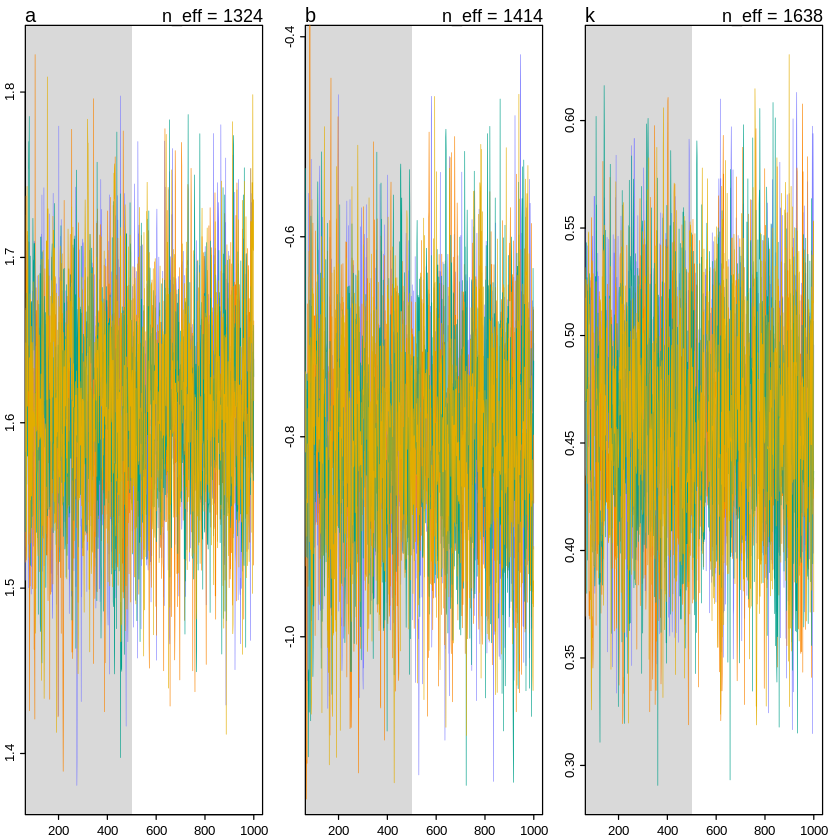

In [54]:
traceplot(m15.6)

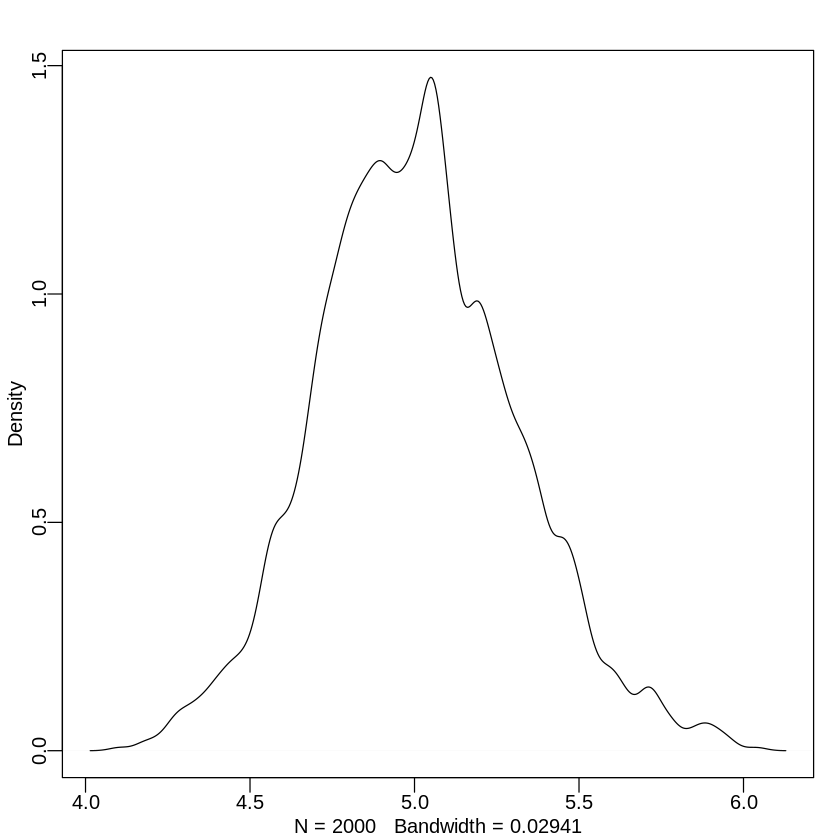

In [60]:
# Calculate estimates of alpha and beta in simulation
post <- extract.samples(m15.6)
alpha_est <- exp(post$a)
dens(alpha_est)

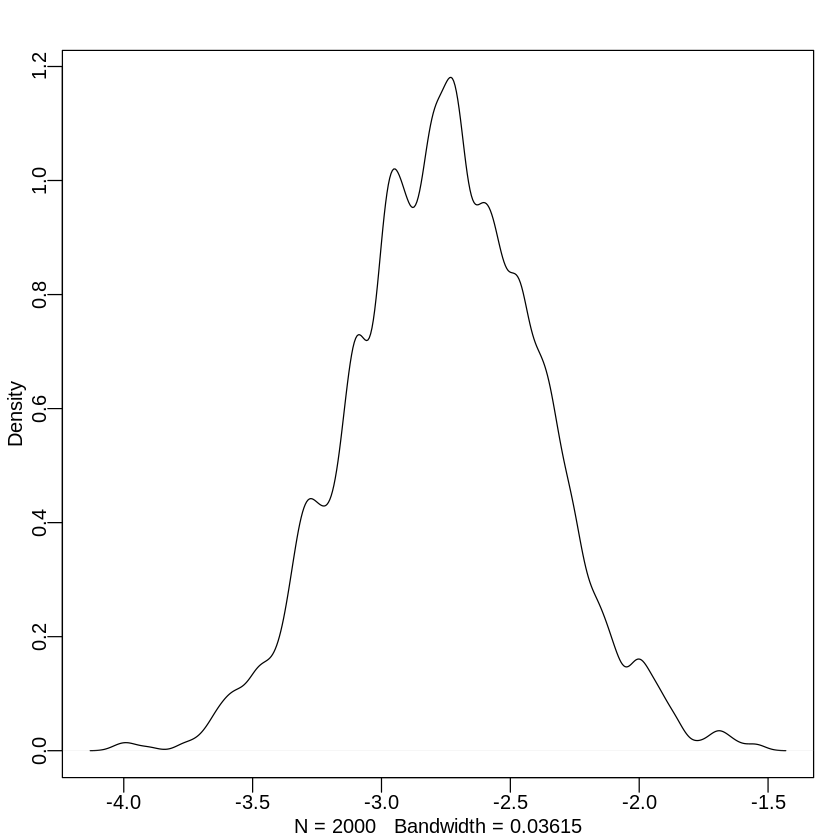

In [63]:
beta_est <- exp(post$a + post$b) - exp(post$a)

dens(beta_est)

In [65]:
m15.7 <- ulam(
            alist(
            
                # singing bird model
                notes|RC==0 ~ poisson( lambda ),
                notes|RC==1 ~ custom( log_sum_exp(
                                        log(k) + poisson_lpmf( notes | exp(a + b) ),
                                        log(1-k) + poisson_lpmf( notes | exp(a) )
                                    ) ),
                log(lambda) <- a + b*cat,
                a ~ normal(0,1),
                b ~ normal(0,0.5),

                # sneaking cat model
                cat|RC==0 ~ bernoulli(k),
                k ~ beta(2,2),

                # imputed values
                gq> vector[N]:PrC1 <- exp(lpC1)/(exp(lpC1)+exp(lpC0)),
                gq> vector[N]:lpC1 <- log(k) + poisson_lpmf( notes[i] | exp(a+b) ),
                gq> vector[N]:lpC0 <- log(1-k) + poisson_lpmf( notes[i] | exp(a) )
                
            ), data=dat , chains=4 , cores=4 )

In [67]:
precis(m15.7, depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,1.6092082,0.06088410,1.5121731,1.7050814,1391.098,1.0003881
b,-0.8028794,0.11407786,-0.9895865,-0.6216357,1584.703,1.0001574
k,0.4623417,0.05545502,0.3748232,0.5519062,1911.354,1.0007481
lpC0[1],-3.9530515,0.25233836,-4.3736461,-3.5693055,1433.079,0.9987758
lpC0[2],-2.5581000,0.11504368,-2.7496902,-2.3863254,1725.507,0.9989512
lpC0[3],-2.3753191,0.12914094,-2.5937369,-2.1811695,1728.426,1.0026024
lpC0[4],-2.5982330,0.17181144,-2.8930216,-2.3380970,1587.332,1.0025882
lpC0[5],-2.5982330,0.17181144,-2.8930216,-2.3380970,1587.332,1.0025882
lpC0[6],-2.5581000,0.11504368,-2.7496902,-2.3863254,1725.507,0.9989512


PRACTICE

14E1

14E2

14M1

Similar to answer in https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch14_hw.R:

Model m15.3 from section [15.2.2] models missed neocortex values as drawn from the Gaussian distribution with parameters `nu` and `sigma_B`.  These parameters are fitted using the available values of B, and reflect the sample average brain size and standard error.  

On the other hand, model m15.5 uses in addition the available information of correlation of B with body mass to determine the missing B values by sampling them from a joint multivariate normal distribution.

14M2

See the models m15.3 - m15.5 above, from around box 25 onwards, in particular the compare function calculations.

From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch14_hw.R:

"I think it is not correct to compare WAIC of models fitted with neocortex imputation and model on complete cases only.  This model use data with different number of rows, so I would expect that WAIC of the model with imputation will be higher just because it has 12 more cases in the sum. Let's check it. I use code from the book to fit both models."

In [85]:
data(milk)
d <- milk
head(d)

clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NA
Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NA
Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NA
Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NA
New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54


In [86]:
sapply( d[,c("kcal.per.g","mass","neocortex.perc")] , function(x) sum(is.na(x)) )

kcal.per.g           mass neocortex.perc 
             0              0             12

In [87]:
d2 <- d[ complete.cases( d$kcal.per.g, d$mass, d$neocortex.perc ) , ]
nrow(d2)

[1] 17

In [92]:
compare( m15.3 , m15.4 , m15.5 )

Warning message in compare(m15.3, m15.4, m15.5):
“Different numbers of observations found for at least two models.
Information criteria only valid for comparing models fit to exactly same observations.
Number of observations for each model:
m15.3 29 
m15.4 17 
m15.5 29 
”Warning message in waic_ptw1 - waic_ptw2:
“longer object length is not a multiple of shorter object length”Warning message in waic_ptw1 - waic_ptw2:
“longer object length is not a multiple of shorter object length”

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m15.4,46.06928,2.679992,0.00000,9.999995e-01,4.933149,NA
m15.5,75.71978,4.604177,29.65050,3.643131e-07,5.826069,7.896774
m15.3,77.59299,4.955646,31.52371,1.427948e-07,5.720588,10.082182


As expected, the WAIC is substanctially higher when including more data points.  As the warning message says, it is not valid to compare m15.4 with the other two models because it has fewer observations.  On the other hand, the comparison between the model m15.3 and m15.5 demonstrates the superior ability of the model that allows the correlation between B and M to be learned from the data and used to impute the missing B values:

Warning message in compare(m15.3, m15.4, m15.5):
“Different numbers of observations found for at least two models.
Information criteria only valid for comparing models fit to exactly same observations.
Number of observations for each model:
m15.3 29 
m15.4 17 
m15.5 29 
”Warning message in waic_ptw1 - waic_ptw2:
“longer object length is not a multiple of shorter object length”Warning message in waic_ptw1 - waic_ptw2:
“longer object length is not a multiple of shorter object length”

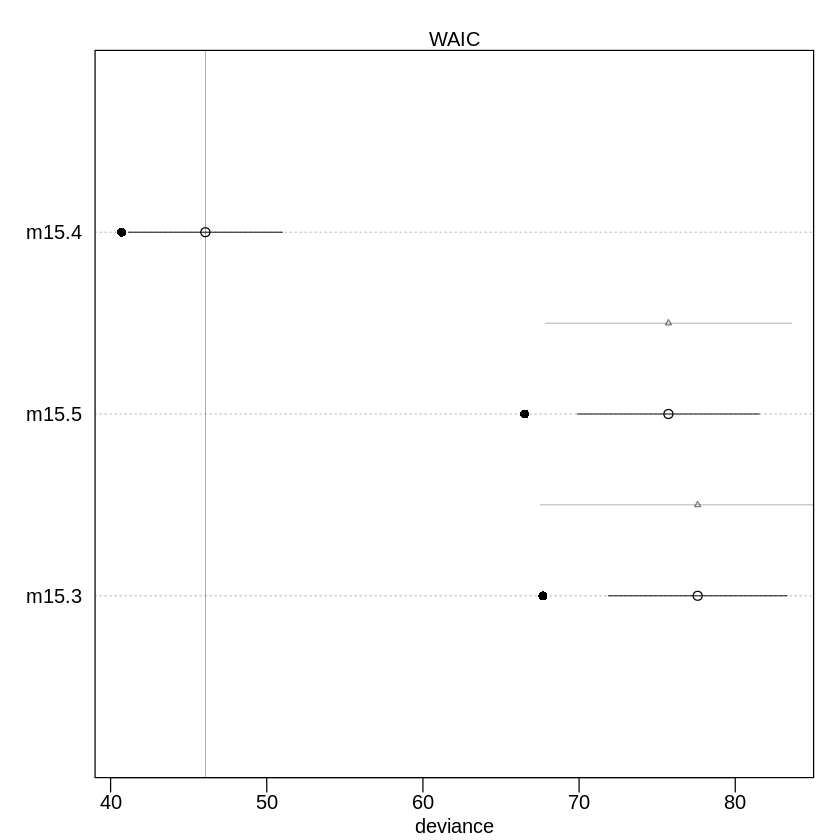

In [93]:
plot( compare( m15.3 , m15.4 , m15.5 ) )

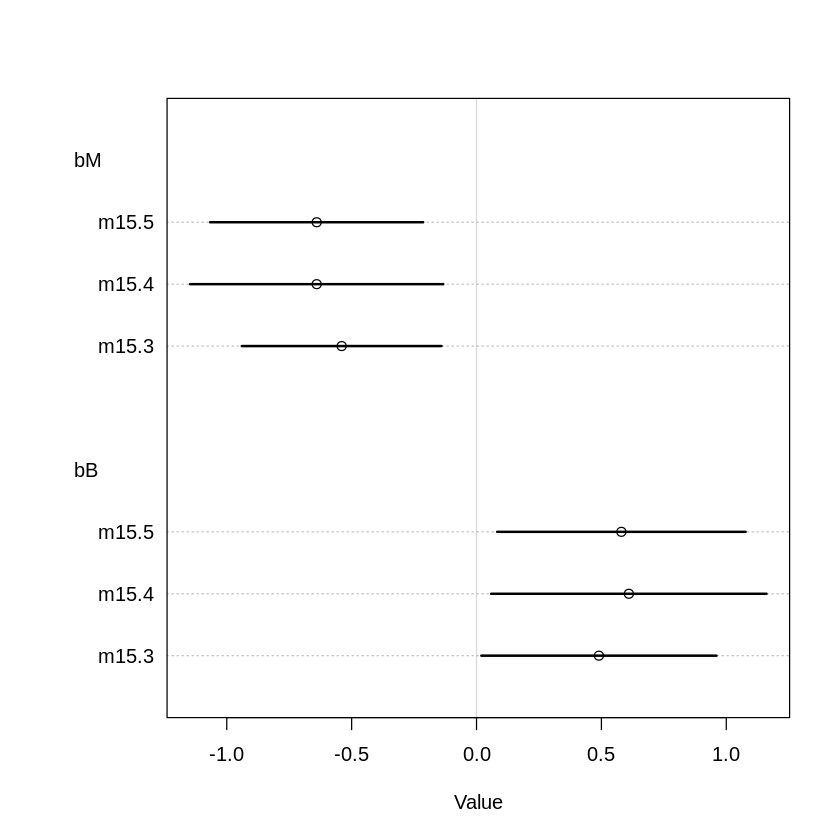

In [94]:
plot( coeftab( m15.3 , m15.4 , m15.5 ) , pars=c("bM","bB") )

In [101]:
data(WaffleDivorce)
d <- WaffleDivorce

In [102]:
dlist <- list(
                D_obs = standardize( d$Divorce ),
                D_sd = d$Divorce.SE / sd( d$Divorce ),
                M = standardize( d$Marriage ),
                A = standardize( d$MedianAgeMarriage ),
                N = nrow(d)
            )

m15.1 <- ulam(
                alist(
                D_obs ~ dnorm( D_true , D_sd ),
                vector[N]:D_true ~ dnorm( mu , sigma ),
                mu <- a + bA*A + bM*M,
                a ~ dnorm(0,0.2),
                bA ~ dnorm(0,0.5),
                bM ~ dnorm(0,0.5),
                sigma ~ dexp(1)
                ) , data=dlist , chains=4 , cores=4 )

recompiling to avoid crashing R session


In [103]:
dlist <- list(
                D_obs = standardize( d$Divorce ),
                D_sd = d$Divorce.SE / sd( d$Divorce ),
                M_obs = standardize( d$Marriage ),
                M_sd = d$Marriage.SE / sd( d$Marriage ),
                A = standardize( d$MedianAgeMarriage ),
                N = nrow(d)
            )

m15.2 <- ulam(
                alist(
                    D_obs ~ dnorm( D_est , D_sd ),
                    vector[N]:D_est ~ dnorm( mu , sigma ),
                    mu <- a + bA*A + bM*M_est[i],
                    M_obs ~ dnorm( M_est , M_sd ),
                    vector[N]:M_est ~ dnorm( 0 , 1 ),
                    a ~ dnorm(0,0.2),
                    bA ~ dnorm(0,0.5),
                    bM ~ dnorm(0,0.5),
                    sigma ~ dexp( 1 )
                ) , data=dlist , chains=4 , cores=4 )

recompiling to avoid crashing R session


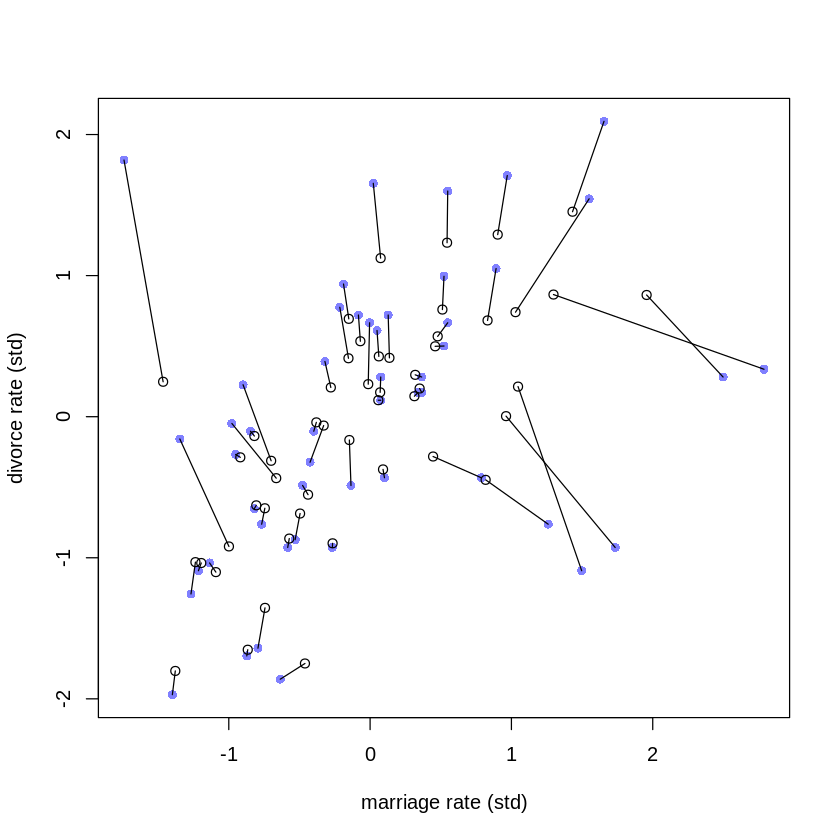

In [104]:
post <- extract.samples( m15.2 )

D_est <- apply( post$D_est , 2 , mean )
M_est <- apply( post$M_est , 2 , mean )

plot( dlist$M_obs , dlist$D_obs , pch=16 , col=rangi2, 
                 xlab="marriage rate (std)" , ylab="divorce rate (std)" )
points( M_est , D_est )
for ( i in 1:nrow(d) ) lines( c( dlist$M_obs[i] , M_est[i] ) , c( dlist$D_obs[i] , D_est[i] ) )

In [121]:
dlist_double <- list(
                D_obs = standardize( d$Divorce ),
                D_sd = d$Divorce.SE / sd( d$Divorce ),
                M_obs = standardize( d$Marriage ),
                M_sd = d$Marriage.SE / sd( d$Marriage ),
                A = standardize( d$MedianAgeMarriage ),
                N = nrow(d)
            )

m15.2.doubleSE <- ulam(
                alist(
                    D_obs ~ dnorm( D_est , 2*D_sd ),
                    vector[N]:D_est ~ dnorm( mu , sigma ),
                    mu <- a + bA*A + bM*M_est[i],
                    M_obs ~ dnorm( M_est , 2*M_sd ),
                    vector[N]:M_est ~ dnorm( 0 , 1 ),
                    a ~ dnorm(0,0.2),
                    bA ~ dnorm(0,0.5),
                    bM ~ dnorm(0,0.5),
                    sigma ~ dexp( 1 )
                ) , data=dlist_double , chains=4 , cores=4
#                 , control=list(adapt_delta=0.99)
                )

recompiling to avoid crashing R session
Warning message:
“There were 9 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

From 

"Model didn't converge. It looks like we couldn't rely on inferred results because an effective number of samples is small and Rhat is very large.
iter=1e+4, warmup=5000 
Increasing number of iterations for warmup helped to reduce Rhat to 1 for almost all parameters, but n_eff is still very low (~300).
From these two observations I conclude that with larger deviance of observations inference becomes harder."


In [123]:
precis(m15.2.doubleSE)

100 vector or matrix parameters hidden. Use depth=2 to show them.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.08079116,0.10351224,-0.250025288,0.08301317,618.12336,1.001655
bA,-0.60271009,0.15001238,-0.844216594,-0.36501749,359.05656,1.011973
bM,0.33769379,0.20350771,0.005446539,0.65533559,197.28104,1.012692
sigma,0.16666562,0.09452011,0.056949307,0.34186393,56.54498,1.055076


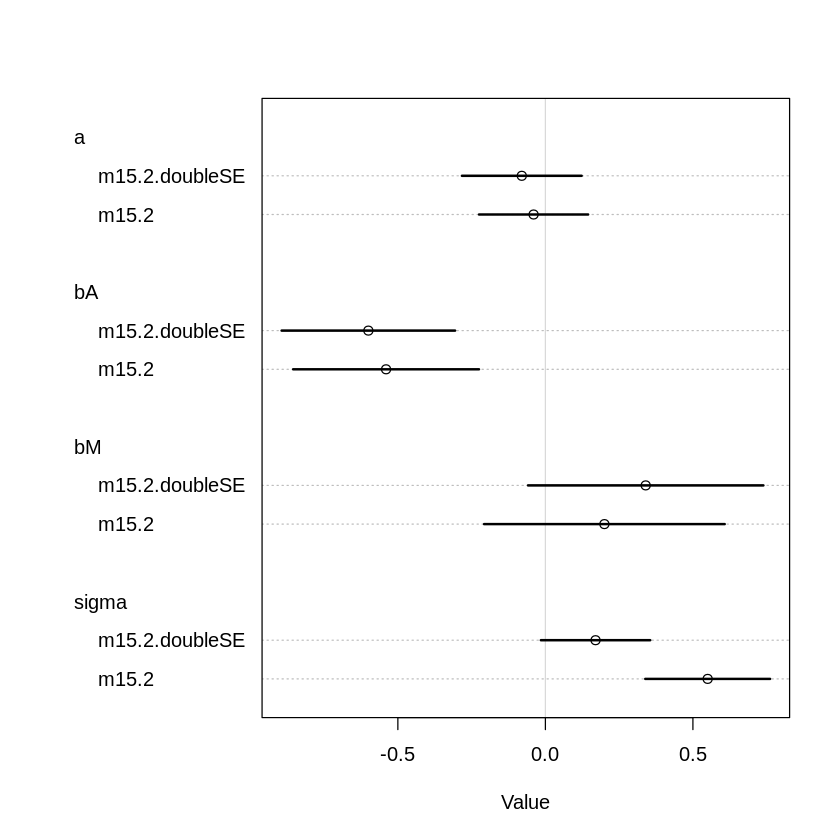

In [124]:
plot(coeftab(m15.2, m15.2.doubleSE) , pars=c("a","bA","bM","sigma") )

The effects of 'doubling' the standard errors is not so predictable, because the variables we use are standardized.  Perhaps this question was more appropriate in the 1st edition of the book, when the variables may not have been standardized.  

Despite this, there is a clear reduction in the magnitude of the sigma distribution.  This may be understood as occurring because doubling the D_sd allows any variation in D_obs to be explained by the additional D_sd, weakening the link between variation in D_obs and variation in D_est.  Thus, the D_est is not required to vary as strongly to explain variation in D_obs, so D_est can have a smaller standard deviation around mu (which is what the sigma variable corresponds to).

14H1

In [1]:
library(rethinking)
data(elephants)
d <- elephants
head(d)


Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


AGE,MATINGS
<int>,<int>
27,0
28,1
28,1
28,1
28,3
29,0


In [147]:
m14H1 <- ulam(
            alist(
                MATINGS ~ poisson(lambda),                
                log(lambda) <- a + b*AGE,
                a ~ normal(0, 1),
                b ~ normal(0, 1)
                ), data=d, cores=4, chains=4, log_lik=TRUE
            )

In [142]:
precis(m14H1)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-1.23552138,0.44689596,-1.95881843,-0.52321996,465.2541,1.003737
b,0.05982296,0.01149941,0.04159822,0.07801251,473.7684,1.002813


In [4]:
d$id <- 1:nrow(d)

In [171]:
dat <- list(AGE=as.numeric(d$AGE), id=d$id, MATINGS=d$MATINGS)

m14H1se <- ulam(
            alist(
                MATINGS ~ dpois(lambda),                                
                AGE ~ dnorm(AGE_true[id], 5),
                AGE_true[id] ~ dnorm(AGEbar, sigma),
                
                #Link function
                log(lambda) <- a + b*AGE_true[id],
                
                #Priors
                a ~ dnorm(0, 1),
                b ~ dnorm(0, 1),
                
                #Hyper-priors
                AGEbar ~ dnorm(38, 3),
                sigma ~ dexp(0.1)
                ), data=dat, cores=4, chains=4, log_lik=TRUE
            )

Cautionary note:
Variable AGE contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.


In [172]:
precis(m14H1se)

41 vector or matrix parameters hidden. Use depth=2 to show them.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-1.78227712,0.70172656,-2.92602050,-0.6655697,1136.9184,1.002429
b,0.07525136,0.01854386,0.04608115,0.1054408,1077.6760,1.002311
AGEbar,36.04413046,1.07640928,34.36264297,37.8179433,1537.2960,0.999802
sigma,5.43034529,1.03764266,3.89101137,7.1587325,581.1705,1.006054


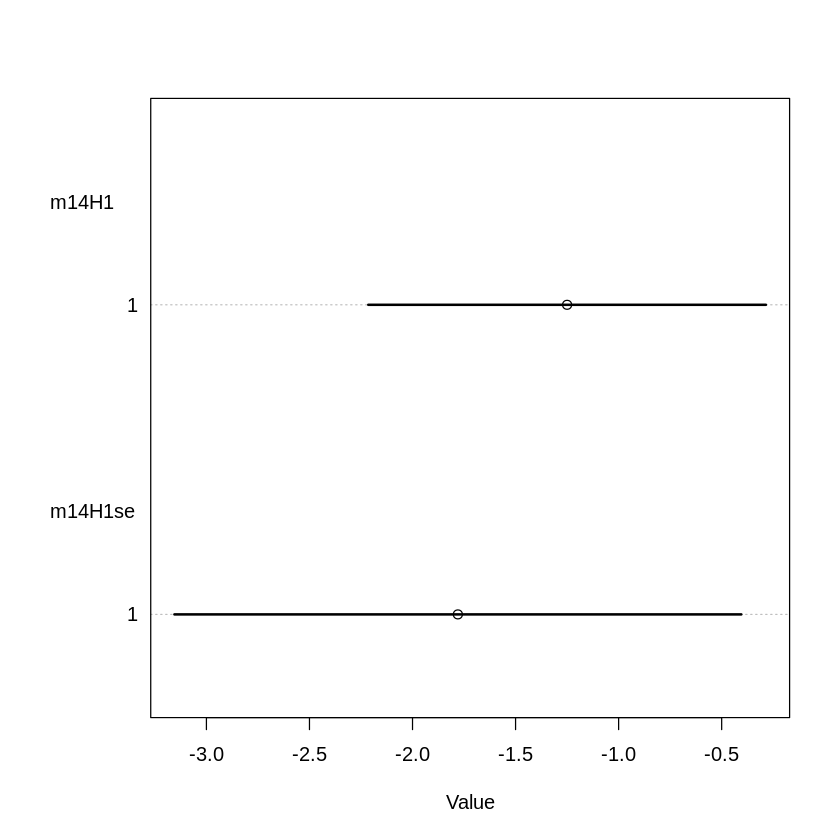

In [176]:
plot(coeftab(m14H1, m14H1se), pars=c("a"))

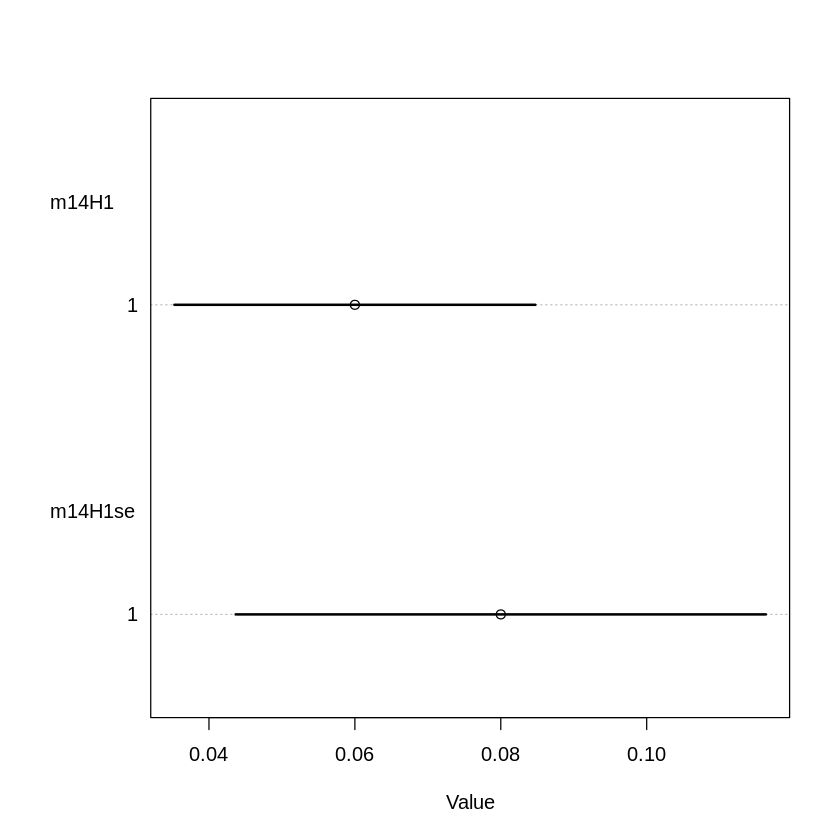

In [178]:
plot(coeftab(m14H1, m14H1se), pars=c("b"))

We plot a and b on two different charts as the scales are different and make it difficult to see the changes in b.

While the uncertainty of the parameters has increased once we add measurement error into the model, both parameter a and b have increased in absolute magnitude (so have 'strenghtened', away from 0).

14H2

In [18]:
dat <- list(AGE=as.numeric(d$AGE), id=d$id, MATINGS=d$MATINGS)

m14H2 <- ulam(
            alist(
                MATINGS ~ dpois(lambda),                                
                AGE ~ dnorm(AGE_true[id], 8000),
                AGE_true[id] ~ dnorm(AGEbar, sigma),
                
                #Link function
                log(lambda) <- a + b*AGE_true[id],
                
                #Priors
                a ~ dnorm(0, 1),
                b ~ dnorm(0, 1),
                
                #Hyper-priors
                AGEbar ~ dnorm(38, 3),
                sigma ~ dexp(0.1)
                ), data=dat, cores=4, chains=4, log_lik=TRUE
            )

Cautionary note:
Variable AGE contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.
Warning message:
“There were 13 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [26]:
precis(m14H2)

41 vector or matrix parameters hidden. Use depth=2 to show them.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.21002061,1.08043733,-1.75233311,1.92192618,31.68407,1.081235
b,0.02934941,0.02913693,-0.02870796,0.07040638,30.29538,1.086110
AGEbar,37.74226959,2.90378809,33.12464131,42.31925283,235.98134,1.015362
sigma,13.70546901,11.57007179,0.69554303,34.27928151,21.48065,1.147737


41 vector or matrix parameters hidden. Use depth=2 to show them.


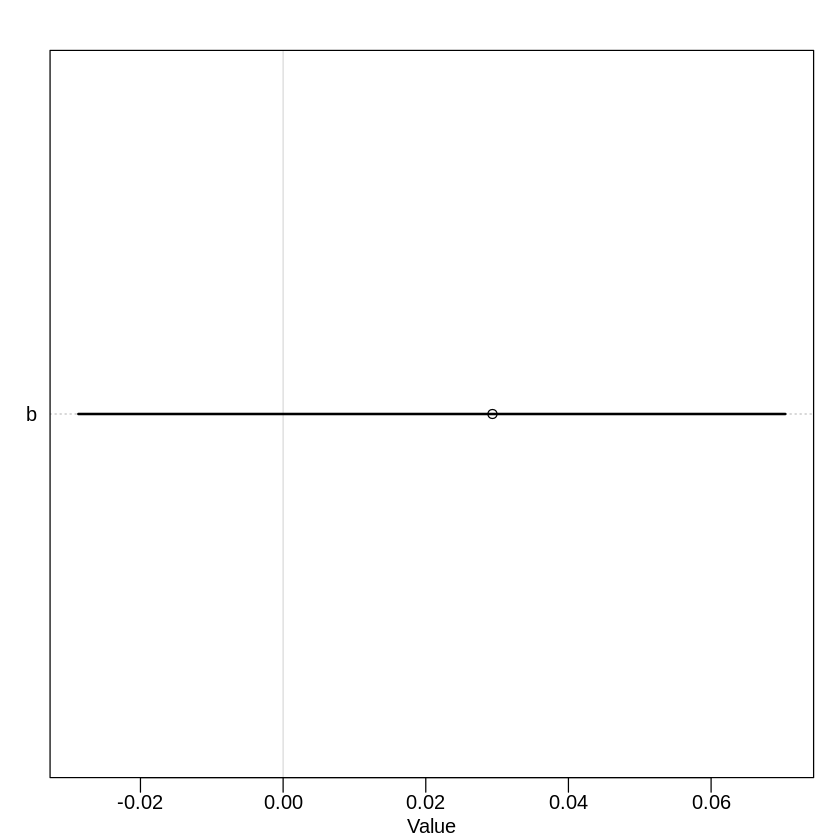

In [20]:
plot(precis(m14H2), pars="b")

From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch14_hw.R:

In [21]:
m14h2 <- map2stan(
  alist(
    MATINGS ~ dpois(lambda),
    log(lambda) ~ a + b*AGE_est[i],
    AGE ~ dnorm(AGE_est, 40),
    a ~ dnorm(0,10),
    b ~ dnorm(0,1)
  ),
  data=d, 
  start=list(AGE_est=d$AGE),
  iter=4000, chains=2, cores=2
)

Computing WAIC


In [22]:
precis(m14h2)

41 vector or matrix parameters hidden. Use depth=2 to show them.


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.31972130,0.228060043,-0.059328091,0.66196343,1863.321,1.001327
b,0.01404377,0.003581835,0.008703545,0.02006246,1545.323,1.000795


41 vector or matrix parameters hidden. Use depth=2 to show them.


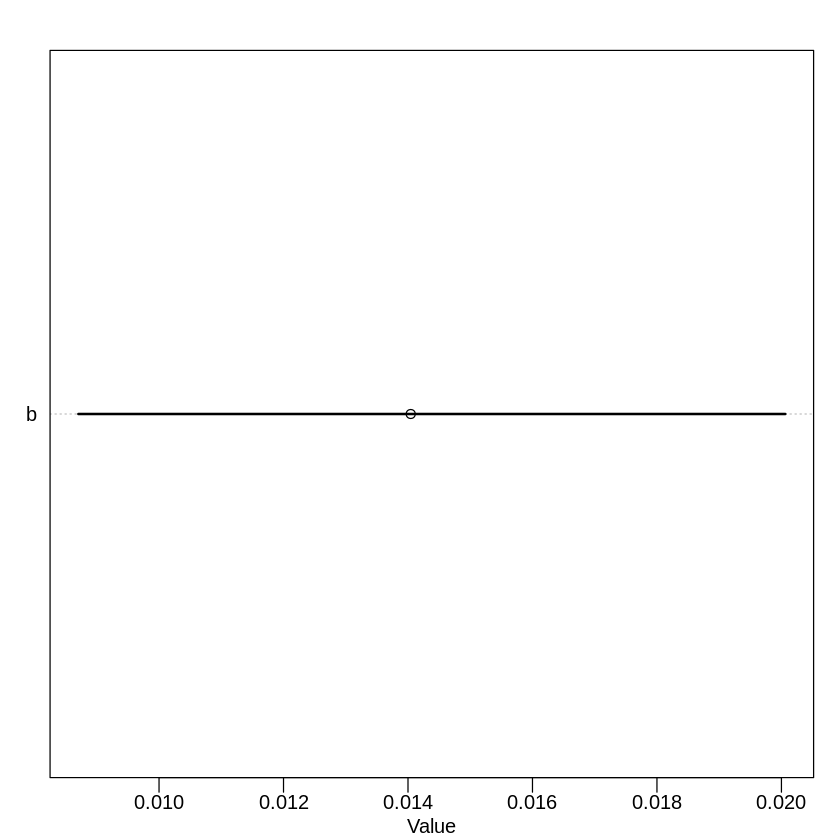

In [24]:
plot(precis(m14h2), pars="b")

I think this question relied upon the workings of map2stan and other things from the 1st edition of the book that are not applicable to this, such as using 'start' to define the starting values of map2stan.

In our model using ulam, we have to define a prior (and hyper-priors) for AGE_true.  This different type of model is more stable to changes in the standard deviation of the distribution from which AGE is sampled.  Hence we cannot get b down to near 0 as easily as in this latter model using map2stan.  The sd of the parameter b is an order of magnitude larger than b from the map2stan model, hence although the mean is further from 0 in the ulam model, a large part of the distribution already cross to negative values, unlike in the latter map2stan model.

14H3

In [102]:
set.seed(100)
x <- c( rnorm(10) )
y <- c( rnorm(10,x)  )
d <- list(x=x,y=y)

In [103]:
m14H3 <- ulam(
            alist(
                y ~ dnorm(mu, sigma),
                mu <- a + b * x,
                a ~ dnorm(0, 1),
                b ~ dnorm(0, 1),
                sigma ~ dexp(1)
                ), data=d, cores=4, chains=4
            )

recompiling to avoid crashing R session


In [104]:
precis(m14H3)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.2086740,0.2977100,-0.2718855,0.667976,1380.483,1.002355
b,1.0663057,0.5089794,0.2269129,1.844773,1397.062,1.000044
sigma,0.9584046,0.2547924,0.6380055,1.427030,1232.037,1.000457


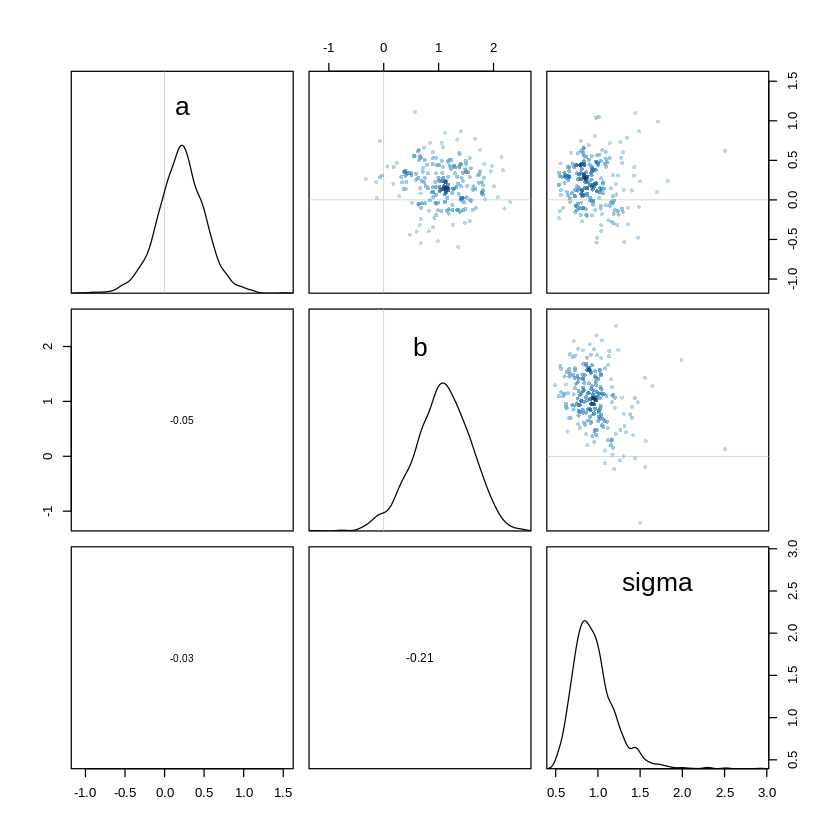

In [109]:
pairs(m14H3)

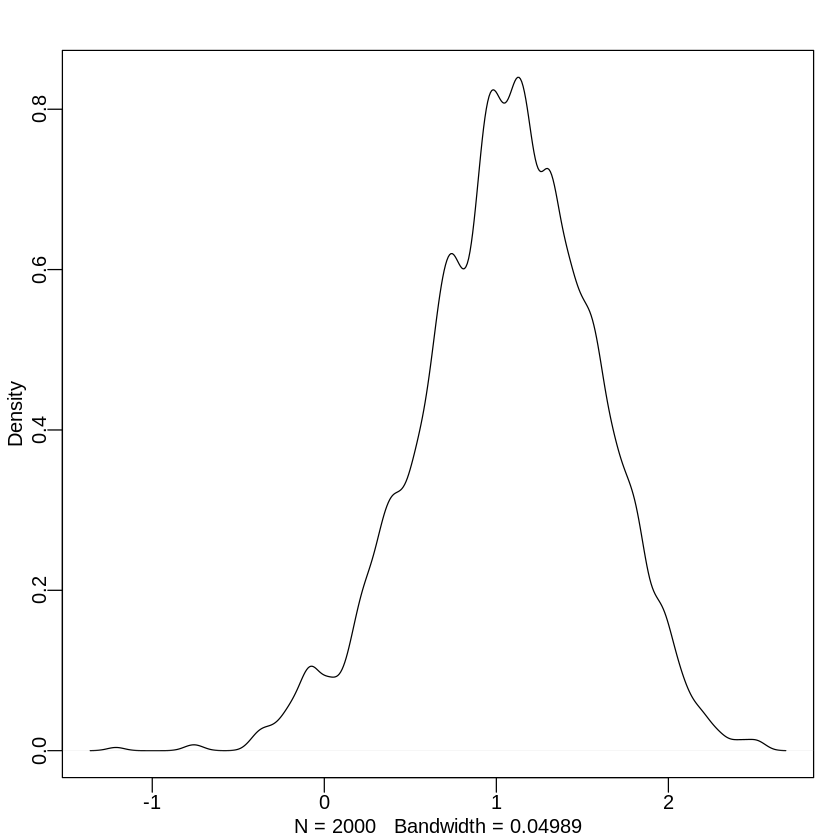

In [105]:
post <- extract.samples(m14H3)
dens(post$b)

In [114]:
set.seed(100)
x <- c( rnorm(10) , NA, NA )
y <- c( rnorm(10,x) , 100, 100 )
d <- list(x=x,y=y)
d

$x
 [1] -0.50219235  0.13153117 -0.07891709  0.88678481  0.11697127  0.31863009
 [7] -0.58179068  0.71453271 -0.82525943 -0.35986213          NA          NA

$y
 [1]  -0.4123062   0.2278056  -0.2805510   1.6266253   0.2403508   0.2893134
 [7]  -0.9706449   1.2253890  -1.7390736   1.9504347 100.0000000 100.0000000

In [115]:
m14H3.impute <- ulam(
                    alist(
                        y ~ dnorm(mu, sigma),
                        mu <- a + b * x,                        
                        x ~ dnorm(0, 1),
                        a ~ dnorm(0, 1),
                        b ~ dnorm(0, 1),                        
                        sigma ~ dexp(1)                       
                        ), data=d, cores=4, chains=4
                    )

Found 2 NA values in x and attempting imputation.
recompiling to avoid crashing R session


In [116]:
precis(m14H3.impute, depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.358049332,1.026600,-1.283577,2.003828,2792.027,0.9996293
b,-0.008013503,1.027785,-1.694421,1.590147,2419.807,1.0002538
sigma,24.125432532,2.473685,20.456416,28.534874,2432.217,0.9992843
x_impute[1],-0.001594890,1.027804,-1.608023,1.629451,2565.662,0.9992478
x_impute[2],0.013519954,1.012378,-1.575526,1.594070,2763.237,0.9996738


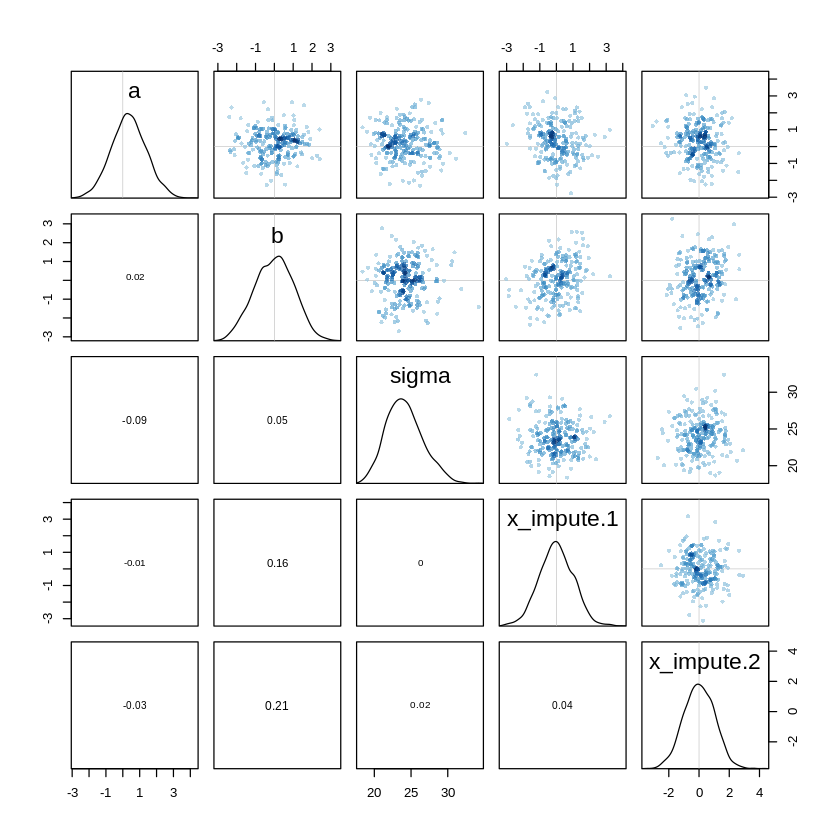

In [117]:
pairs(m14H3.impute)

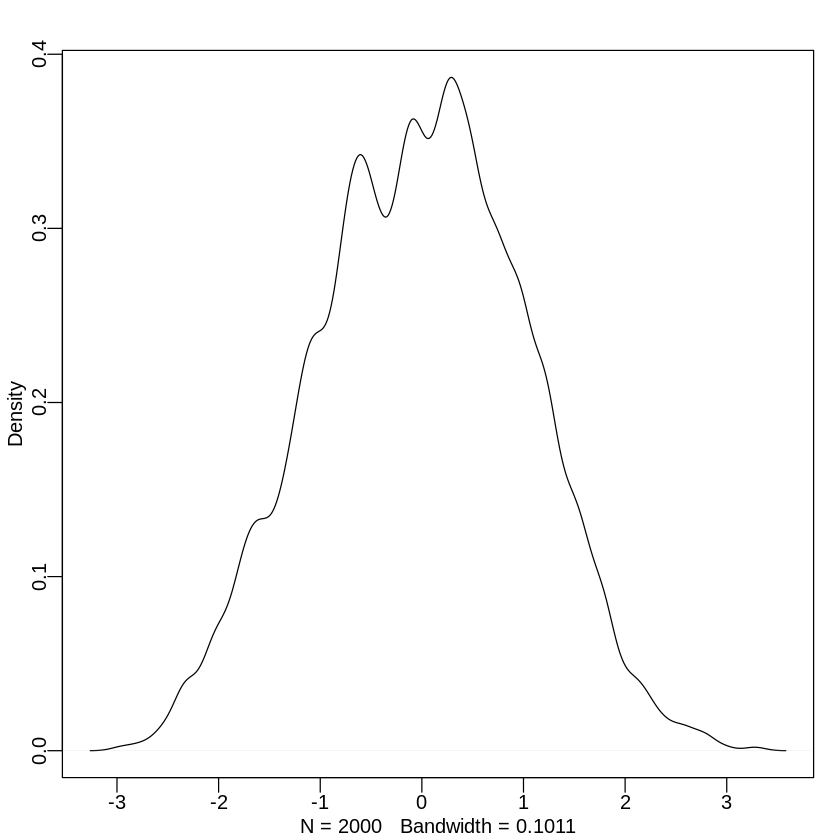

In [118]:
post.impute <- extract.samples(m14H3.impute)
dens(post.impute$b)

The width of b is much greater after including the missing data and getting the model to impute it.

Sigma is much larger in this version of the model (~ 24).  This is probably because we include the values of y that equal 100.  All the other values of y are around the values of between -2 and +2, so the values of 100 are a big shock to the model.  Because there is no comparable values of y to relate to the x values, in order to handle this big jump in values, the estimation of sigma has substantially increased from around 1 in the complete cases model to 24 now, to try to explain this variation.

However, all known values of x are still much much smaller than any that would be needed to generate a value for y of 100 (based on what the model estimates are the values of a and b, based on the known data).  In fact, the imputed values for x are all still around 0, with around half the probability being for negative values of x.  And these negative values of x would require large negative values of b to achieve values of y anywhere near 100.  So the uncertainty (standard error) of b increases.

The model tries to incorporate the y=100 values using the y ~ norm(mu=a + b * x, sigma) as the likelihood.  It does this by simultaneously (i) increasing sigma to increase the likelihood of getting y, given what we know of the parameters from the actual data, (ii) adjusting parameters a and b, (iii) adjusting the imputed values x_impute[1 and 2].

In [119]:
set.seed(100)
x <- c( rnorm(10) , NA )
y <- c( rnorm(10,x) , 100 )
d3 <- list(x=x,y=y)

m14H3.impute <- ulam(
                    alist(
                        y ~ dnorm(mu, sigma),
                        mu <- a + b * x,                        
                        x ~ dnorm(0, 1),
                        a ~ dnorm(0, 1),
                        b ~ dnorm(0, 1),                        
                        sigma ~ dexp(1)                       
                        ), data=d3, cores=4, chains=4
                    )

Found 1 NA values in x and attempting imputation.
SYNTAX ERROR, MESSAGE(S) FROM PARSER:
No matches for: 

  merge_missing(int, vector, vector)

Available argument signatures for merge_missing:

  merge_missing(int[ ], vector, vector)

 error in 'modela9614ab1d28_4e8cdc0881522ce370b2788e37228441' at line 31, column 62
  -------------------------------------------------
    29:     b ~ normal( 0 , 1 );
    30:     a ~ normal( 0 , 1 );
    31:     x_merge = merge_missing(x_missidx, to_vector(x), x_impute);
                                                                     ^
    32:     x_merge ~ normal( 0 , 1 );
  -------------------------------------------------



ERROR: Error in stanc(file = file, model_code = model_code, model_name = model_name, : failed to parse Stan model '4e8cdc0881522ce370b2788e37228441' due to the above error.


The above is a bug with the code I think.  Clearly, the underlying code in ulam that calls merge_missing does not convert single missing values into an array of length 1, and there is no merge_missing signature that can handle int (it expects int[]).  I have demonstrated that adding two missing values fixes this problem.  I have contacted the author to report the bug.